In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
import torch.nn as nn

In [4]:
!pip install albumentations==1.0.0
import albumentations as A

     |████████████████████████████████| 98 kB 4.0 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [5]:
import albumentations 
from albumentations.pytorch import ToTensorV2
import numpy as np

In [6]:
from model import Net
from utils import *

In [7]:
from train_eval import *

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform = transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [9]:
mean, std = get_mean_std(trainloader)
mean, std

(tensor([0.4913, 0.4821, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils


horizontalflip_prob = 0.2
rotate_limit = 15
shiftscalerotate_prob = 0.25
num_holes = 1
cutout_prob = 0.5

train_transforms, test_transforms = data_albumentations(horizontalflip_prob,rotate_limit,
                                                                      shiftscalerotate_prob,num_holes,cutout_prob,trainloader)

                  

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform = train_transforms)

test_set  = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=test_transforms)


train_loader = torch.utils.data.DataLoader(train_set, 
                                          batch_size=64, 
                                          shuffle=True,
                                          num_workers=2, 
                                          pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_set, 
                                            batch_size=64,  
                                            shuffle=False,
                                            num_workers=2, 
                                            pin_memory=True)
        

Files already downloaded and verified
Files already downloaded and verified


# Plot Images

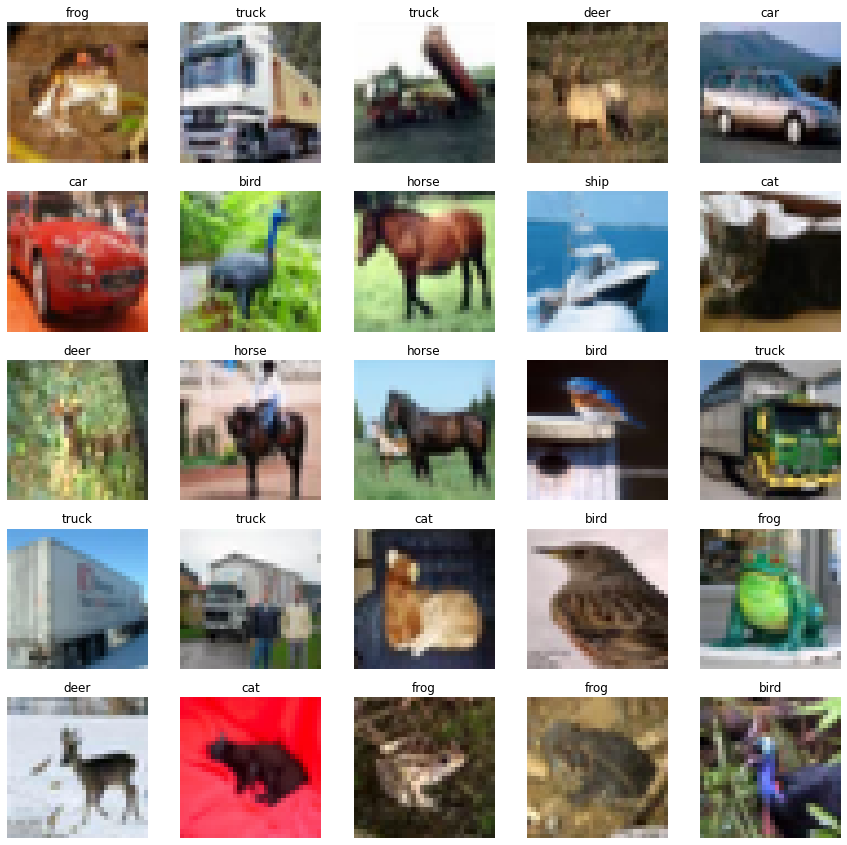

In [11]:
N_IMAGES = 25

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

images, labels = zip(*[(image, label) for image, label in 
                           [trainset[i] for i in range(N_IMAGES)]])


plot_images(images, labels, classes)

In [12]:
net = Net()

In [13]:
from torchsummary import summary
summary(net.cuda(), (3, 32, 32)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,080
           Conv2d-10           [-1, 32, 16, 16]             288
           Conv2d-11           [-1, 32, 16, 16]           9,216
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

# Training

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

l2_factor = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3) #, weight_decay=l2_factor

epochs = 5

scheduler2 =ReduceLROnPlateau(optimizer=optimizer, verbose=True)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=78200, epochs=epochs)   # steps_per_epoch = len(train_loader)

In [17]:
EPOCHS = epochs

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_valid_loss = float('inf')

l1_factor = 0

for epoch in range(EPOCHS):
    
    train_loss, train_acc = train(net, train_loader, optimizer, scheduler, criterion, l1_factor, device)
    valid_loss, valid_acc = evaluate(net, test_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), '96K-model.pth')
    
    print(f'Epoch: {epoch+1:02} ')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 
	Train Loss: 1.523 | Train Acc: 46.47%
	 Val. Loss: 1.271 |  Val. Acc: 56.45%
Epoch: 02 
	Train Loss: 1.301 | Train Acc: 55.27%
	 Val. Loss: 1.025 |  Val. Acc: 66.03%
Epoch: 03 
	Train Loss: 1.162 | Train Acc: 60.17%
	 Val. Loss: 0.917 |  Val. Acc: 69.19%
Epoch: 04 
	Train Loss: 1.068 | Train Acc: 63.72%
	 Val. Loss: 0.836 |  Val. Acc: 71.56%
Epoch: 05 
	Train Loss: 1.000 | Train Acc: 66.03%
	 Val. Loss: 0.767 |  Val. Acc: 74.24%


In [ ]:
 EPOCHS = epochs

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_valid_loss = float('inf')

l1_factor = 0

for epoch in range(EPOCHS):
    
    train_loss, train_acc = train(net, train_loader, optimizer, scheduler, criterion, l1_factor, device)
    valid_loss, valid_acc = evaluate(net, test_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), '96K-model.pth')
    
    print(f'Epoch: {epoch+1:02} ')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 
	Train Loss: 1.697 | Train Acc: 39.85%
	 Val. Loss: 1.318 |  Val. Acc: 54.59%
Epoch: 02 
	Train Loss: 1.366 | Train Acc: 53.32%
	 Val. Loss: 1.066 |  Val. Acc: 64.01%
Epoch: 03 
	Train Loss: 1.197 | Train Acc: 59.35%
	 Val. Loss: 0.963 |  Val. Acc: 67.69%
Epoch: 04 
	Train Loss: 1.092 | Train Acc: 63.05%
	 Val. Loss: 0.866 |  Val. Acc: 71.11%
Epoch: 05 
	Train Loss: 1.021 | Train Acc: 65.30%
	 Val. Loss: 0.803 |  Val. Acc: 73.05%
Epoch: 06 
	Train Loss: 0.963 | Train Acc: 67.25%
	 Val. Loss: 0.737 |  Val. Acc: 75.37%
Epoch: 07 
	Train Loss: 0.918 | Train Acc: 68.91%
	 Val. Loss: 0.714 |  Val. Acc: 76.22%
Epoch: 08 
	Train Loss: 0.887 | Train Acc: 69.62%
	 Val. Loss: 0.690 |  Val. Acc: 76.73%
Epoch: 09 
	Train Loss: 0.853 | Train Acc: 71.05%
	 Val. Loss: 0.678 |  Val. Acc: 77.37%
Epoch: 10 
	Train Loss: 0.836 | Train Acc: 71.73%
	 Val. Loss: 0.646 |  Val. Acc: 78.44%
Epoch: 11 
	Train Loss: 0.809 | Train Acc: 72.54%
	 Val. Loss: 0.615 |  Val. Acc: 79.44%
Epoch: 12 
	Train Los

In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


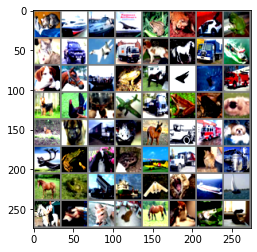

In [21]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
images,labels = images.to(device),labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 90 %
Accuracy of  bird : 65 %
Accuracy of   cat : 52 %
Accuracy of  deer : 67 %
Accuracy of   dog : 62 %
Accuracy of  frog : 85 %
Accuracy of horse : 76 %
Accuracy of  ship : 87 %
Accuracy of truck : 76 %
